# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow

以下のsolution関数のみ編集してください。

In [3]:
def alexet(input_shape=(227, 227, 3), num_classes=1000):
    import tensorflow as tf
    layers = tf.keras.layers
    model = tf.keras.models.Sequential()

    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding="valid"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

    model.add(layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding="same"))

    model.add(layers.Conv2D(384, (3, 3), strides=(1, 1), activation='relu', padding="same"))

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

def show_img(image):
    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def solution(x_test_df, train_df):
    import tensorflow as tf
    import numpy as np
    from PIL import Image

    failure_types = list(train_df['failureType'].unique())
    # 前処理
    normalized_train_maps = np.array([np.asarray(Image.fromarray(x).resize((128,128))) for x in train_df['waferMap'] / 2.0])
    normalized_train_maps = normalized_train_maps.reshape(normalized_train_maps.shape + (1,))
    print(normalized_train_maps.shape)
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']])
    show_img(normalized_train_maps[0])
    model = alexet(input_shape=(128,128,1),num_classes=len(failure_types))
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    model.fit(normalized_train_maps, train_labels)
    buf = normalized_train_maps
    normalized_train_maps = np.rot90(buf, k=1, axes=(1, 2))
    del buf
    model.fit(normalized_train_maps, train_labels)
    buf = normalized_train_maps
    normalized_train_maps = np.rot90(buf, k=1, axes=(1, 2))
    del buf
    model.fit(normalized_train_maps, train_labels)
    buf = normalized_train_maps
    normalized_train_maps = np.rot90(buf, k=1, axes=(1, 2))
    del buf
    model.fit(normalized_train_maps, train_labels)
    
    normalized_test_maps = np.array([np.asarray(Image.fromarray(x).resize((128,128))) for x in x_test_df['waferMap'] / 2.0])
    normalized_test_maps = normalized_test_maps.reshape(normalized_test_maps.shape + (1,))
    test_index = [x for x in x_test_df['waferIndex']]
    predictions = model.predict(normalized_test_maps)
    answer = [failure_types[x.argmax()] for x in predictions]
    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)


solution関数は以下のように活用され、平均精度を計算します。

(22967, 128, 128, 1)


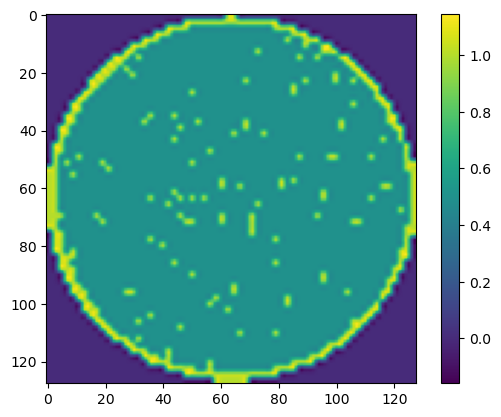

2023-11-12 13:43:02.563099: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1505165312 exceeds 10% of free system memory.
/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


718/718 [==============================] - 193s 265ms/step - loss: 0.6898 - accuracy: 0.7636


2023-11-12 13:46:37.639455: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1505165312 exceeds 10% of free system memory.


658/718 [==========================>...] - ETA: 16s - loss: 0.4998 - accuracy: 0.8176

In [ ]:
%%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")